In [0]:
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch.nn.functional as F
from torch.distributions import Normal
import torch.nn as nn
import os
import torch.optim as optim

In [0]:
def sample_data():
  count = 100000
  rand = np.random.RandomState(0)
  a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
  c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
  -np.sin(np.linspace(0, np.pi, count // 3))]

  c += rand.randn(*c.shape) * 0.2
  data_x = np.concatenate([a, b, c], axis=0)
  data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
  perm = rand.permutation(len(data_x))
  return data_x[perm], data_y[perm]

X shape:  (99999, 2)
y shape:  (99999,)


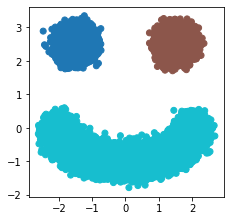

In [60]:
X, y = sample_data()
print("X shape: ", X.shape)
print("y shape: ", y.shape)

plt.figure(figsize=(3.5, 3.5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10')
plt.show()

In [4]:
split = int(0.8 * 100000)
X_train, X_test = X[:split,], X[split:,]
y_train, y_test = y[:split,], y[split:,]

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (80000, 2)
X_test shape:  (19999, 2)


In [0]:
class DataLoader:
  def __init__(self, data, target, batch_size=10):
    self.data = data
    self.target = target
    self.batch_size = batch_size

  def next(self):
    m, _ = self.data.shape
    rand_index = np.random.choice(m, size=m)
    X, y = self.data[rand_index], self.target[rand_index]
    pos = 0
    while pos < m:
      X_batch, y_batch = X[pos:pos+self.batch_size], y[pos:pos+self.batch_size]
      yield (X_batch, y_batch)
      pos += self.batch_size

  def __call__(self):
    return self.next()

### Autoregressive Flow

In [0]:
class BufferedLinear(nn.Linear):
  def __init__(self, in_features, out_features, bias=True):
    super(BufferedLinear, self).__init__(in_features, out_features, bias=bias)
    self.register_buffer("buffer", torch.ones([out_features, in_features]).float())
      
  def set_buffer(self, buffer):
    self.buffer = buffer.data
      
  def forward(self, x):
    return F.linear(x, self.buffer * self.weight, self.bias)
    
class BaseNN(nn.Module):
  def __init__(self, k, hidden_size):
    super(BaseNN, self).__init__()
    self.k = k
    self.h = hidden_size
    
    buf1 = np.ones([self.h, 2], dtype=np.float32)
    buf1[:, 1] = 0.0
    self.linear1 = BufferedLinear(2, self.h)
    self.linear1.set_buffer(torch.from_numpy(buf1))
    
    buf2 = np.ones([2 * k, self.h], dtype=np.float32)
    buf2[:k, :] = 0.0
    self.linear2 = BufferedLinear(self.h, 2 * k)
    self.linear2.set_buffer(torch.from_numpy(buf2))

In [0]:
class CoeffNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    lin2 = lin2.reshape([-1, 2, self.k])
    sftmx = F.softmax(lin2, dim=2)
    return sftmx
    
class MeanNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    lin2 = lin2.view([-1, 2, self.k])
    return lin2
    
class VarNN(BaseNN):
  def __init__(self, k, hidden_size):
    super().__init__(k, hidden_size)
      
  def forward(self, x):
    lin1 = self.linear1(x)
    h = F.relu(lin1)
    lin2 = self.linear2(h)
    exp = torch.exp(lin2)
    out = exp.view([-1, 2, self.k])
    return out

In [0]:
class MyModel:
  def __init__(self, k, hidden_size):
    self.coeffNN = CoeffNN(k, hidden_size).cuda()
    self.meanNN = MeanNN(k, hidden_size).cuda()
    self.varNN = VarNN(k, hidden_size).cuda()

  def loss(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_dens = coeff * torch.exp(-torch.pow(x - mean, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var)
    dens = torch.sum(w_dens, dim=2)
    return -torch.log(torch.abs(dens[:, 0] * dens[:, 1]))

  def parameters(self):
    return list(self.coeffNN.parameters()) + list(self.meanNN.parameters()) + list(self.varNN.parameters())

  def density(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_dens = coeff * torch.exp(-torch.pow(x - mean, 2) / (2 * var)) / torch.sqrt(2 * np.pi * var)
    dens = torch.sum(w_dens, dim=2)
  
    return torch.abs(dens[:, 0] * dens[:, 1]).detach()

  def latent(self, x):
    coeff, mean, var = self.coeffNN(x), self.meanNN(x), self.varNN(x)
    x = x.unsqueeze(2)
    w_cdf = coeff * (torch.erf((x - mean) / torch.sqrt(2 * var)) + 1) / 2
    cdf = torch.sum(w_cdf, dim=2)
    return cdf


In [0]:
# Hyperparameters
k = 10
hidden_size = 100
lr = 1e-3
NUM_EPOCHS = 20
BATCH_SIZE = 256

In [82]:
model = MyModel(k, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

dataloader = DataLoader(np.array(X_train), np.array(y_train), batch_size=BATCH_SIZE)

train_x = []
train_losses = []
val_x = []
val_losses = []

global_step = 0

val_loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
val_loss = val_loss / (2 * np.log(2))
val_x.append(global_step)
val_losses.append(val_loss.item())

for epoch in range(NUM_EPOCHS):
  idx = np.random.permutation(X_train.shape[0])
  loss = None

  for data in dataloader():
    inputs, targets = data
    batch = torch.from_numpy(inputs).float().cuda()
    
    loss = torch.mean(model.loss(batch))
    
    if (global_step + 1) % 300 == 0:
      print(f"EPOCH:{epoch + 1}/{NUM_EPOCHS}, GLOBAL_STEP:{global_step + 1} LOSS={loss.item()}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss = loss.detach() / (2 * np.log(2))
    train_x.append(global_step)
    train_losses.append(train_loss.item())
    
    global_step += 1
      
  val_loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
  val_loss = val_loss / (2 * np.log(2))
  val_x.append(global_step)
  val_losses.append(val_loss.item())


EPOCH:1/20, GLOBAL_STEP:300 LOSS=2.216279983520508
EPOCH:2/20, GLOBAL_STEP:600 LOSS=2.0862932205200195
EPOCH:3/20, GLOBAL_STEP:900 LOSS=2.0607614517211914
EPOCH:4/20, GLOBAL_STEP:1200 LOSS=1.9754637479782104
EPOCH:5/20, GLOBAL_STEP:1500 LOSS=1.9218899011611938
EPOCH:6/20, GLOBAL_STEP:1800 LOSS=1.6625055074691772
EPOCH:7/20, GLOBAL_STEP:2100 LOSS=1.5648685693740845
EPOCH:8/20, GLOBAL_STEP:2400 LOSS=1.5122599601745605
EPOCH:9/20, GLOBAL_STEP:2700 LOSS=1.354689598083496
EPOCH:10/20, GLOBAL_STEP:3000 LOSS=1.5290889739990234
EPOCH:11/20, GLOBAL_STEP:3300 LOSS=1.3241058588027954
EPOCH:12/20, GLOBAL_STEP:3600 LOSS=1.3593299388885498
EPOCH:13/20, GLOBAL_STEP:3900 LOSS=1.329845666885376
EPOCH:14/20, GLOBAL_STEP:4200 LOSS=1.3039350509643555
EPOCH:15/20, GLOBAL_STEP:4500 LOSS=1.3802318572998047
EPOCH:16/20, GLOBAL_STEP:4800 LOSS=1.4227311611175537
EPOCH:17/20, GLOBAL_STEP:5100 LOSS=1.3817288875579834
EPOCH:18/20, GLOBAL_STEP:5400 LOSS=1.371143102645874
EPOCH:19/20, GLOBAL_STEP:5700 LOSS=1.3618139

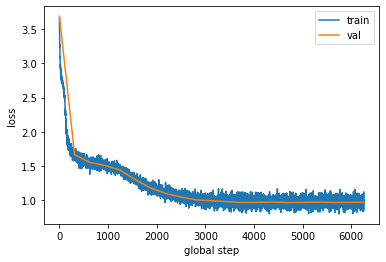

Final test performance: 0.9676092863082886


In [83]:
plt.plot(train_x, train_losses, label="train")
plt.plot(val_x, val_losses, label="val")
plt.xlabel("global step")
plt.ylabel("loss")
plt.legend()
plt.show()

loss = torch.mean(model.loss(torch.from_numpy(X_test).float().cuda()).detach())
bits = loss / (2 * np.log(2))
print(f"Final test performance: {bits.item()}")

([<matplotlib.axis.YTick at 0x7fac0232e048>,
 <a list of 9 Text yticklabel objects>)

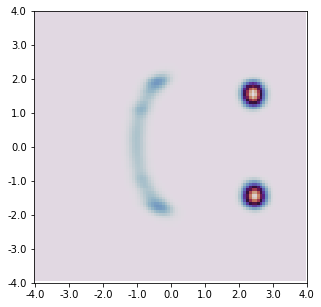

In [94]:
space = np.linspace(-4, 4, 100)

samples = torch.from_numpy(np.array(np.meshgrid(space, space)).T.reshape([-1, 2])).float().cuda()
pdf = model.density(samples).cpu().data.numpy().reshape(100, 100)

plt.figure(figsize=(5, 5))
plt.imshow(pdf, cmap="twilight")
plt.xticks(np.linspace(0, 100, 9), np.linspace(-4, 4, 9))
plt.yticks(np.linspace(0, 100, 9), np.linspace(4, -4, 9))

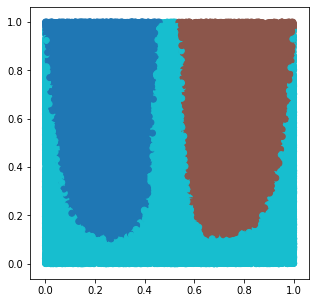

In [111]:
lat = model.latent(torch.from_numpy(X).float().cuda()).data.cpu().data.numpy()
plt.figure(figsize=(5, 5))
plt.scatter(lat[:, 0], lat[:, 1], c=y, cmap='tab10')
plt.show()

### RealNVP